# 05 — Monte Carlo Option Pricing

This notebook walks through the theory and implementation of **Monte Carlo simulation**
for European and American option pricing.

**Roadmap**

1. Notebook setup (imports, parameters)
2. GBM dynamics — the SDE and its exact solution
3. Euler discretisation — spot form and log form
4. European pricing — simulate, average, discount
5. Path visualisation — spaghetti plots
6. Pricing with `portfolio_analytics`
7. Variance reduction — antithetic variates and control variates
8. Jump diffusion (Merton 1976)
9. American options — Longstaff–Schwartz (2001)
10. Greeks via Monte Carlo
11. Convergence and diagnostics
12. Discrete dividends in Monte Carlo
13. Summary

## 1) Notebook Setup

We use the `portfolio_analytics` package for all pricing.  Key objects:

| Class / Enum | Purpose |
|---|---|
| `DiscountCurve.flat(...)` | Flat risk-free rate curve |
| `MarketData` | Bundles pricing date + discount curve |
| `UnderlyingPricingData` | Spot, vol, market data, dividends |
| `OptionSpec` | Contract terms (type, exercise, strike, maturity) |
| `OptionValuation` | Dispatcher — routes to MC engine |
| `MonteCarloParams` | Paths, seed, LSM degree, control variate |
| `PricingMethod.MONTE_CARLO` | Selects the Monte Carlo engine |
| `GBMProcess` | GBM path simulator |
| `JDProcess` | Merton jump-diffusion path simulator |
| `SimulationConfig` | Path count, grid, antithetic/moment-matching flags |

In [1]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from portfolio_analytics import (
    DiscountCurve,
    MarketData,
    OptionType,
    ExerciseType,
    PricingMethod,
    BinomialParams,
    MonteCarloParams,
    OptionSpec,
    OptionValuation,
    UnderlyingPricingData,
    SimulationConfig,
    GBMParams,
    JDParams,
    GBMProcess,
    JDProcess,
)

In [2]:
# ── Market / contract parameters ──────────────────────────────────────
pricing_date = dt.datetime(2025, 1, 1)
maturity = dt.datetime(2026, 1, 1)

S0 = 100.0  # spot
K = 100.0  # strike (ATM)
sigma = 0.20  # volatility
r = 0.05  # risk-free rate
q = 0.02  # continuous dividend yield

# Build flat curves
T = 1.0  # year fraction
curve_r = DiscountCurve.flat(r, end_time=T)
curve_q = DiscountCurve.flat(q, end_time=T)

market_data = MarketData(pricing_date, curve_r, currency="USD")

underlying = UnderlyingPricingData(
    initial_value=S0,
    volatility=sigma,
    market_data=market_data,
    dividend_curve=curve_q,
)

spec_call = OptionSpec(
    option_type=OptionType.CALL,
    exercise_type=ExerciseType.EUROPEAN,
    strike=K,
    maturity=maturity,
    currency="USD",
)

# BSM reference price (for comparison throughout)
bsm_ov = OptionValuation(
    underlying=underlying,
    spec=spec_call,
    pricing_method=PricingMethod.BSM,
)
bsm_pv = bsm_ov.present_value()

print(f"Spot: {S0},  Strike: {K},  σ: {sigma},  r: {r},  q: {q},  T: {T}")
print(f"BSM reference price: {bsm_pv:.6f}")

Spot: 100.0,  Strike: 100.0,  σ: 0.2,  r: 0.05,  q: 0.02,  T: 1.0
BSM reference price: 9.227006


## 2) GBM Dynamics — The SDE and Its Exact Solution

Under the risk-neutral measure, the stock price follows **geometric Brownian motion** (GBM):

$$dS_t = (r - q)\,S_t\,dt + \sigma\,S_t\,dW_t,$$

where $r$ is the risk-free rate, $q$ is the continuous dividend yield, $\sigma$ is the volatility,
and $W_t$ is a standard Brownian motion.

The SDE has an **exact solution** (via Itô's lemma on $\ln S$):

$$S_T = S_0 \exp\!\left[\left(r - q - \tfrac{1}{2}\sigma^2\right)T + \sigma\sqrt{T}\,Z\right],$$

where $Z \sim \mathcal{N}(0, 1)$.  This is the **exact** one-step formula — no discretisation error.

More generally, for any interval $[t, t + \Delta t]$:

$$S_{t+\Delta t} = S_t \exp\!\left[\left(r - q - \tfrac{1}{2}\sigma^2\right)\Delta t + \sigma\sqrt{\Delta t}\,Z\right].$$

For European options under GBM, the single-step formula ($t = 0 \to T$) suffices — we only need $S_T$.

## 3) Euler Discretisation — Spot Form and Log Form

When the path itself matters (path-dependent options, American exercise, jump diffusion), we need to **discretise** the SDE over $N$ time steps with $\Delta t = T / N$.

### Spot-space Euler discretisation

Applying the Euler–Maruyama scheme directly to the SDE $dS = (r-q)S\,dt + \sigma S\,dW$:

$$S_{t+\Delta t} = S_t \bigl[1 + (r - q)\Delta t + \sigma \sqrt{\Delta t}\,Z_t\bigr].$$

This is simple but has a flaw: for large $\sigma$ or $\Delta t$, the factor in brackets can go negative, producing **negative stock prices**.  The error is $\mathcal{O}(\Delta t)$ 
(it ignores higher order Ito terms).

### Log-space Euler discretisation (exact for GBM)

Applying Itô's lemma, let $X_t = \ln S_t$.  The log-price SDE is:

$$dX_t = \left(r - q - \tfrac{1}{2}\sigma^2\right)dt + \sigma\,dW_t.$$

This is **arithmetic Brownian motion** in $X$, so the Euler scheme is exact:

$$X_{t+\Delta t} = X_t + \left(r - q - \tfrac{1}{2}\sigma^2\right)\Delta t + \sigma \sqrt{\Delta t}\,Z_t.$$

Converting back: $S_{t+\Delta t} = \exp(X_{t+\Delta t})$.

Benefits:
- **Exact** for GBM (no discretisation error regardless of $\Delta t$)
- Additive increments in log-space: easy to accumulate as a cumulative sum
- Stock price is automatically **positive**: $S = e^X > 0$

This is why `portfolio_analytics` (and most production code) simulates in **log-space**.

> In `GBMProcess.generate_paths()`, the code computes
> `log_increments = drift + diffusion` and then `S₀ * exp(cumsum(log_increments))`.

In [3]:
# ── Compare spot-space vs log-space Euler for a single path ─────────
N_steps_demo = 252  # daily steps
dt_step = T / N_steps_demo
rng = np.random.default_rng(42)
Z = rng.standard_normal(N_steps_demo)

# Spot-space Euler
S_euler = np.zeros(N_steps_demo + 1)
S_euler[0] = S0
for i in range(N_steps_demo):
    S_euler[i + 1] = S_euler[i] * (1 + (r - q) * dt_step + sigma * np.sqrt(dt_step) * Z[i])

# Log-space Euler (exact for GBM)
X = np.zeros(N_steps_demo + 1)
X[0] = np.log(S0)
drift_log = (r - q - 0.5 * sigma**2) * dt_step
for i in range(N_steps_demo):
    X[i + 1] = X[i] + drift_log + sigma * np.sqrt(dt_step) * Z[i]
S_log = np.exp(X)

# Exact solution (single step S_0 → S_T)
S_exact_T = S0 * np.exp(
    (r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * sum(Z * np.sqrt(dt_step) / np.sqrt(T))
)

print("Terminal values (same Z draws):")
print(f"  Spot-space Euler:   {S_euler[-1]:.6f}")
print(f"  Log-space Euler:    {S_log[-1]:.6f}")
print(f"  Difference:         {abs(S_euler[-1] - S_log[-1]):.6f}")
print(f"  Exact multi-step:   {S_exact_T:.6f}")
print("\nLog-space Euler matches the exact multi-step formula — no discretisation error.")

Terminal values (same Z draws):
  Spot-space Euler:   86.841822
  Log-space Euler:    86.625967
  Difference:         0.215856
  Exact multi-step:   86.625967

Log-space Euler matches the exact multi-step formula — no discretisation error.


## 4) European Pricing — Simulate, Average, Discount

For a European option, the price is the discounted risk-neutral expectation ($\mathbb{E}^\mathbb{Q}$) of the terminal payoff:

$$V_0 = e^{-rT}\,\mathbb{E}^\mathbb{Q}\bigl[\text{payoff}(S_T)\bigr].$$

Monte Carlo estimates this as:

$$\hat{V}_0 = e^{-rT} \cdot \frac{1}{M} \sum_{m=1}^{M} \text{payoff}\bigl(S_T^{(m)}\bigr),$$

where each $S_T^{(m)} = S_0 \exp\!\bigl[(r - q - \tfrac{1}{2}\sigma^2)T + \sigma\sqrt{T}\,Z^{(m)}\bigr]$
is an independent draw.

### Standard error

The MC estimator has standard error $\text{SE} = \hat{\sigma}_{\text{payoff}} / \sqrt{M}$,
where $\hat{\sigma}_{\text{payoff}}$ is the sample std of the discounted payoffs.
Convergence is $\mathcal{O}(1/\sqrt{M})$ — halving the error requires 4× the paths.

In [4]:
# ── European call priced from scratch ─────────────────────────────────
M = 100_000  # number of paths
rng = np.random.default_rng(42)
Z = rng.standard_normal(M)

# Exact one-step simulation (GBM)
S_T = S0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

# Payoff
payoff = np.maximum(S_T - K, 0.0)

# Discount and average
df = np.exp(-r * T)
pv_paths = df * payoff
mc_price = np.mean(pv_paths)
std_error = np.std(pv_paths, ddof=1) / np.sqrt(M)

print(f"Monte Carlo price (M={M:,}):  {mc_price:.6f}")
print(f"Standard error:              {std_error:.6f}")
print(
    f"95% CI:                      [{mc_price - 1.96 * std_error:.4f}, {mc_price + 1.96 * std_error:.4f}]"
)
print(f"BSM analytical:              {bsm_pv:.6f}")
print(f"Error:                       {mc_price - bsm_pv:+.6f}")
print(f"Error (%):                   {(mc_price - bsm_pv) / bsm_pv * 100:+.6f} %")

Monte Carlo price (M=100,000):  9.201616
Standard error:              0.043963
95% CI:                      [9.1154, 9.2878]
BSM analytical:              9.227006
Error:                       -0.025390
Error (%):                   -0.275167 %


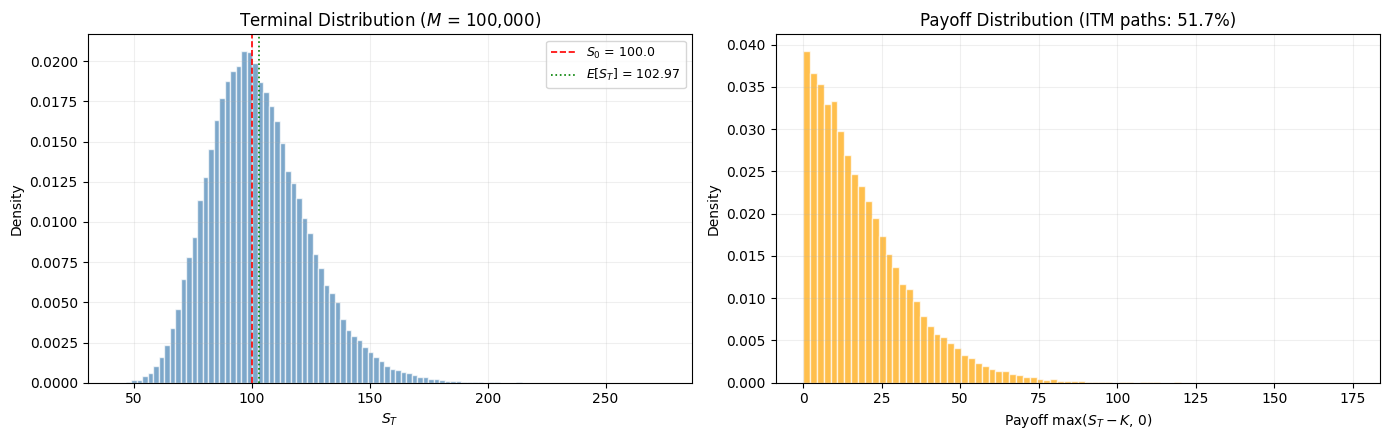

In [5]:
# ── Terminal distribution ──────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

# Histogram of S_T
ax = axes[0]
ax.hist(S_T, bins=100, density=True, alpha=0.7, color="steelblue", edgecolor="white")
ax.axvline(S0, color="red", ls="--", lw=1.2, label=f"$S_0$ = {S0}")
ax.axvline(np.mean(S_T), color="green", ls=":", lw=1.2, label=f"$E[S_T]$ = {np.mean(S_T):.2f}")
ax.set_xlabel("$S_T$")
ax.set_ylabel("Density")
ax.set_title(f"Terminal Distribution ($M$ = {M:,})")
ax.legend(fontsize=9)
ax.grid(alpha=0.2)

# Histogram of payoff (conditional on being > 0)
ax2 = axes[1]
positive_payoff = payoff[payoff > 0]
ax2.hist(positive_payoff, bins=80, density=True, alpha=0.7, color="orange", edgecolor="white")
itm_frac = len(positive_payoff) / M * 100
ax2.set_xlabel("Payoff max($S_T - K$, 0)")
ax2.set_ylabel("Density")
ax2.set_title(f"Payoff Distribution (ITM paths: {itm_frac:.1f}%)")
ax2.grid(alpha=0.2)

plt.tight_layout()
plt.show()

## 5) Path Visualisation

Simulating full paths (not just $S_T$) is useful for understanding the dynamics and is
required for path-dependent payoffs (American, Asian) and jump diffusion.

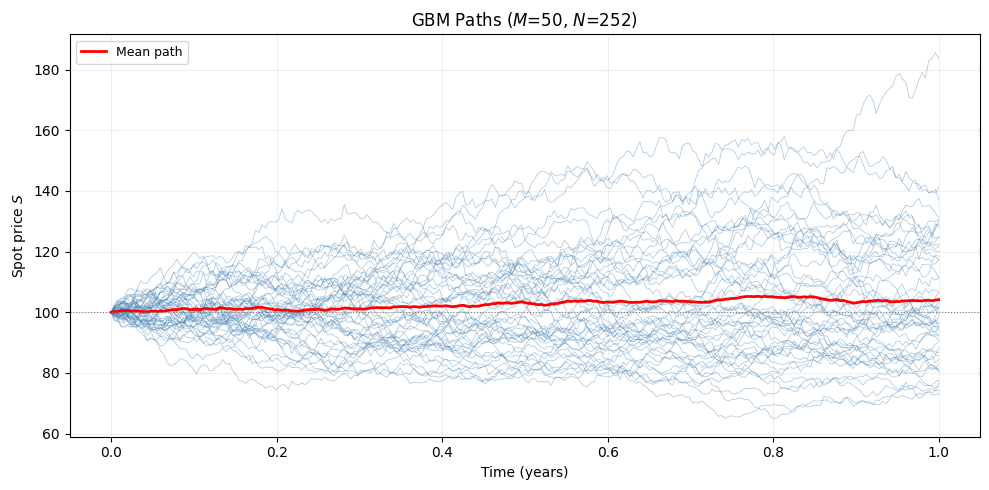

In [6]:
# ── Simulate GBM paths for visualisation ──────────────────────────────
N_plot = 252  # daily steps
M_plot = 50  # number of paths to show
dt_plot = T / N_plot
rng_plot = np.random.default_rng(123)

Z_plot = rng_plot.standard_normal((N_plot, M_plot))
drift_plot = (r - q - 0.5 * sigma**2) * dt_plot
diffusion_plot = sigma * np.sqrt(dt_plot) * Z_plot
log_increments = np.vstack(
    [np.zeros(M_plot), np.full((N_plot, M_plot), drift_plot) + diffusion_plot]
)
paths_gbm = S0 * np.exp(np.cumsum(log_increments, axis=0))

t_axis = np.linspace(0, T, N_plot + 1)

fig, ax = plt.subplots(figsize=(10, 5))
for m in range(M_plot):
    ax.plot(t_axis, paths_gbm[:, m], lw=0.6, alpha=0.4, color="steelblue")
ax.plot(t_axis, np.mean(paths_gbm, axis=1), lw=2, color="red", label="Mean path")
ax.axhline(S0, color="grey", ls=":", lw=0.8)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Spot price $S$")
ax.set_title(f"GBM Paths ($M$={M_plot}, $N$={N_plot})")
ax.legend(fontsize=9)
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## 6) Pricing with `portfolio_analytics`

The library handles all simulation details: path generation, antithetic variates,
moment matching, and payoff evaluation.

For Monte Carlo pricing, the underlying must be a `PathSimulation` instance
(e.g., `GBMProcess`), which wraps the spot, volatility, discount curve,
and simulation configuration together.

In [7]:
# ── European call via the library ──────────────────────────────────────
num_paths = 100_000
num_steps = 1  # single step suffices for European under GBM

sim_config = SimulationConfig(
    paths=num_paths,
    end_date=maturity,
    num_steps=num_steps,
    antithetic=True,
    moment_matching=True,
)

gbm = GBMProcess(
    market_data=market_data,
    process_params=GBMParams(
        initial_value=S0,
        volatility=sigma,
        dividend_curve=curve_q,
    ),
    sim=sim_config,
)

mc_params = MonteCarloParams(random_seed=42)

ov_mc = OptionValuation(
    underlying=gbm,
    spec=spec_call,
    pricing_method=PricingMethod.MONTE_CARLO,
    params=mc_params,
)

mc_pv = ov_mc.present_value()

print(f"Monte Carlo (M={num_paths:,}, seed=42):  {mc_pv:.6f}")
print(f"BSM analytical:                     {bsm_pv:.6f}")
print(f"Error:                              {mc_pv - bsm_pv:+.6f}")
print(f"Error (%):                          {(mc_pv - bsm_pv) / bsm_pv * 100:+.6f} %")

Monte Carlo (M=100,000, seed=42):  9.215369
BSM analytical:                     9.227006
Error:                              -0.011636
Error (%):                          -0.126111 %


In [8]:
# ── MonteCarloParams knobs ────────────────────────────────────────────
print("MonteCarloParams fields:")
print(f"  random_seed:             {mc_params.random_seed}")
print(f"  deg (LSM poly degree):   {mc_params.deg}")
print(f"  std_error_warn_ratio:    {mc_params.std_error_warn_ratio}")
print(f"  control_variate_european:{mc_params.control_variate_european}")
print()
print("SimulationConfig fields:")
print(f"  paths:            {sim_config.paths}")
print(f"  num_steps:        {sim_config.num_steps}")
print(f"  antithetic:       {sim_config.antithetic}")
print(f"  moment_matching:  {sim_config.moment_matching}")

MonteCarloParams fields:
  random_seed:             42
  deg (LSM poly degree):   2
  std_error_warn_ratio:    0.1
  control_variate_european:False

SimulationConfig fields:
  paths:            100000
  num_steps:        1
  antithetic:       True
  moment_matching:  True


In [9]:
# ── Notebook helpers (DRY) ─────────────────────────────────────────────
# Now that we've seen the full explicit construction, define a small
# helper so subsequent cells can focus on the experiment, not boilerplate.

gbm_params = GBMParams(initial_value=S0, volatility=sigma, dividend_curve=curve_q)


def make_gbm(paths, num_steps=1, *, antithetic=True, moment_matching=True, process_params=None):
    """Build a GBMProcess with shared market data and defaults."""
    sim = SimulationConfig(
        paths=paths,
        end_date=maturity,
        num_steps=num_steps,
        antithetic=antithetic,
        moment_matching=moment_matching,
    )
    return GBMProcess(
        market_data=market_data,
        process_params=process_params or gbm_params,
        sim=sim,
    )

## 7) Variance Reduction

Plain Monte Carlo converges at $\mathcal{O}(1/\sqrt{M})$.  Variance reduction techniques
can significantly reduce the number of paths needed for a given accuracy.

### Antithetic variates

For each draw $Z$, also evaluate the payoff at $-Z$.  This pairs each path with its
"mirror" path.  Since GBM payoffs are **monotone** in $Z$, the two are negatively
correlated, reducing variance.

The estimator becomes:

$$\hat{V}_0 = e^{-rT} \cdot \frac{1}{M} \sum_{m=1}^{M/2} \frac{\text{payoff}(S_T^{(+Z_m)}) + \text{payoff}(S_T^{(-Z_m)})}{2}.$$

### Moment matching

After generating the $Z$ draws, re-centre to zero mean and unit variance:
$Z \leftarrow (Z - \bar{Z}) / \hat{\sigma}_Z$.  This ensures the first two moments
of the empirical distribution match the theoretical $\mathcal{N}(0, 1)$ exactly.

### Control variate (for American options)

The BSM European price is known analytically.  If the MC estimate of the European price
from the same simulation has error $\epsilon$, then the American estimate likely has
a similar error.  We correct:

$$\hat{V}_{\text{Am}} = V^{\text{MC}}_{\text{Am}} + \bigl(V^{\text{BSM}}_{\text{Eur}} - V^{\text{MC}}_{\text{Eur}}\bigr).$$

> In `portfolio_analytics`, antithetic variates and moment matching are controlled
> via `SimulationConfig(antithetic=True, moment_matching=True)`.  The American control
> variate is set via `MonteCarloParams(control_variate_european=True)`.

In [10]:
# ── Demonstrate variance reduction impact (lightweight multi-seed check) ─────────
path_counts = [5_000, 10_000]
seeds = [11, 22, 33, 44, 55, 66, 77, 88]  # small fixed set for reproducibility
methods = [
    (False, False, "Plain MC"),
    (True, False, "Antithetic"),
    (False, True, "Moment match"),
    (True, True, "Anti + MM"),
]

print(f"BSM reference: {bsm_pv:.6f}\n")
print(
    f"{'Paths':>7s}  {'Method':<15s}  {'Mean PV':>10s}  {'Mean SE':>10s}  {'Mean |Err|':>10s}  {'RMSE':>10s}"
)
print("-" * 78)

for n_paths in path_counts:
    method_stats = []

    for anti, mm, label in methods:
        pvs = []
        ses = []
        gbm_vr = make_gbm(n_paths, antithetic=anti, moment_matching=mm)

        for seed in seeds:
            ov_vr = OptionValuation(
                underlying=gbm_vr,
                spec=spec_call,
                pricing_method=PricingMethod.MONTE_CARLO,
                params=MonteCarloParams(random_seed=seed),
            )
            pv_pathwise = ov_vr.present_value_pathwise()
            pvs.append(float(np.mean(pv_pathwise)))
            ses.append(float(np.std(pv_pathwise, ddof=1) / np.sqrt(len(pv_pathwise))))

        pvs = np.array(pvs)
        ses = np.array(ses)
        err = pvs - bsm_pv
        mean_pv = float(np.mean(pvs))
        mean_se = float(np.mean(ses))
        mean_abs_err = float(np.mean(np.abs(err)))
        rmse = float(np.sqrt(np.mean(err**2)))

        method_stats.append((label, mean_pv, mean_se, mean_abs_err, rmse))
        print(
            f"{n_paths:7,d}  {label:<15s}  {mean_pv:10.6f}  {mean_se:10.6f}  {mean_abs_err:10.6f}  {rmse:10.6f}"
        )

    best = min(method_stats, key=lambda x: x[3])  # by Mean |Err|
    print(f"  -> Best at {n_paths:,} paths (by Mean |Err|): {best[0]}\n")

BSM reference: 9.227006

  Paths  Method              Mean PV     Mean SE  Mean |Err|        RMSE
------------------------------------------------------------------------------
  5,000  Plain MC           9.306736    0.197695    0.082639    0.109153
  5,000  Antithetic         9.166797    0.194020    0.110289    0.124733
  5,000  Moment match       9.231537    0.196582    0.024241    0.027647
  5,000  Anti + MM          9.232011    0.195518    0.038049    0.040297
  -> Best at 5,000 paths (by Mean |Err|): Moment match

 10,000  Plain MC           9.257210    0.138739    0.113880    0.129691
 10,000  Antithetic         9.251933    0.138769    0.074498    0.099753
 10,000  Moment match       9.234613    0.138766    0.015743    0.017307
 10,000  Anti + MM          9.226417    0.138353    0.015648    0.018637
  -> Best at 10,000 paths (by Mean |Err|): Anti + MM



## 8) Jump Diffusion (Merton 1976)

The Merton jump-diffusion model adds **Poisson-driven jumps** to GBM:

$$\frac{dS}{S} = (r - q - \lambda \bar{k})\,dt + \sigma\,dW + J\,dN_t,$$

where:
- $N_t$ is a Poisson process with intensity $\lambda$ (average jumps per year)
- $J$ is the jump size: $\ln(1 + J) \sim \mathcal{N}(\mu_J, \delta_J^2)$
- $\bar{k} = E[e^{\ln(1+J)} - 1] = e^{\mu_J + \frac{1}{2}\delta_J^2} - 1$ is the drift correction

### Euler discretisation (log-space)

Over a time step $\Delta t$:

$$X_{t+\Delta t} = X_t + \underbrace{(r - q - \lambda\bar{k} - \tfrac{1}{2}\sigma^2)\Delta t}_{\text{adjusted drift}} + \underbrace{\sigma\sqrt{\Delta t}\,Z}_{\text{diffusion}} + \underbrace{\sum_{i=1}^{N_\Delta}Y_i}_{\text{jump magnitude}},$$

where $N_\Delta \sim \text{Poisson}(\lambda \Delta t)$ and $Y_i \sim \mathcal{N}(\mu_J, \delta_J^2)$.

### Unpacking the jump component

**$N_\Delta$** is the number of jumps that occur during the interval $\Delta t$.  Because it is Poisson-distributed, it can only take **non-negative integer** values: $0, 1, 2, \ldots$  Most of the time, for small $\Delta t$ and moderate $\lambda$, $N_\Delta$ will be 0 (no jump) or 1, but values $\geq 2$ are possible.

**$Y_i$** represents the log-magnitude of a **single jump** — one sudden, discrete price movement.  Each $Y_i$ is drawn independently from $\mathcal{N}(\mu_J, \delta_J^2)$, where $\mu_J$ controls the average direction (negative $\mu_J$ biases jumps downward, modelling crashes) and $\delta_J$ controls how variable individual jump sizes are.

**The jump magnitude** $\sum_{i=1}^{N_\Delta} Y_i$ is the **total** contribution of all jumps that land in the interval $\Delta t$.  We are summing $N_\Delta$ independent, identically distributed normal random variables.  Because they are i.i.d.:

- The **mean** of the sum is $N_\Delta \cdot \mu_J$
- The **variance** of the sum is the sum of the variances: $N_\Delta \cdot \delta_J^2$

So the total jump magnitude is itself normally distributed (conditional on $N_\Delta$):

$$\sum_{i=1}^{N_\Delta} Y_i \;\Big|\; N_\Delta \;\sim\; \mathcal{N}\!\left(N_\Delta\,\mu_J,\; N_\Delta\,\delta_J^2\right).$$

### Sampling the jump magnitude in Python

Since we know the conditional distribution above, we don't need to loop and draw $N_\Delta$ individual $Y_i$'s.  Instead we sample the sum directly in three steps:

1. **Sample $N_\Delta$** from a Poisson distribution with rate parameter $\lambda \cdot \Delta t$
2. **Sample $Z_J$** from a standard normal distribution $\mathcal{N}(0, 1)$
3. **Compute** the total jump magnitude as:

$$\sum Y_i = N_\Delta \cdot \mu_J + \sqrt{N_\Delta} \cdot \delta_J \cdot Z_J$$

When $N_\Delta = 0$ the entire expression collapses to zero — no jumps occurred.  The `np.where(poi_counts > 0, ..., 0.0)` guard in the code below is therefore not strictly necessary (the formula gives zero anyway), but it is included for **clarity**.

### Vectorised simulation

We need to sample the jump magnitude **for every path and every time step** — that is, an $(N, M)$ matrix where $N$ is the number of time steps and $M$ is the number of paths.  Rather than looping over paths and time steps, we do this in a **vectorised** manner: sample all $N \times M$ Poisson counts and jump normals in one call each (`rng.poisson(...)` and `rng.standard_normal(...)`), and then compute the jump magnitudes element-wise.

Unlike pure GBM, jump diffusion **requires time stepping** — we can't collapse to a single step
because the Poisson arrivals occur throughout the path.

### Why jump diffusion matters

- Produces **fat tails** and **volatility skew** in the implied vol surface
- Captures sudden large moves (earnings, macro events) that GBM cannot
- The BSM formula is a special case with $\lambda = 0$

In [11]:
# ── Jump diffusion parameters ─────────────────────────────────────────
lambd = 1.0  # ~1 jump per year
mu_J = -0.10  # mean log jump size (negative → crashes)
delta_J = 0.15  # std of log jump size

k_bar = np.exp(mu_J + 0.5 * delta_J**2) - 1

print("Jump diffusion parameters:")
print(f"  λ (intensity):    {lambd} jumps/year")
print(f"  μ_J (mean log):   {mu_J}")
print(f"  δ_J (std log):    {delta_J}")
print(f"  k̄ = E[eʸ-1]:     {k_bar:.6f}")
print(f"  E[jump mult]:     {np.exp(mu_J + 0.5 * delta_J**2):.4f}")

Jump diffusion parameters:
  λ (intensity):    1.0 jumps/year
  μ_J (mean log):   -0.1
  δ_J (std log):    0.15
  k̄ = E[eʸ-1]:     -0.084926
  E[jump mult]:     0.9151


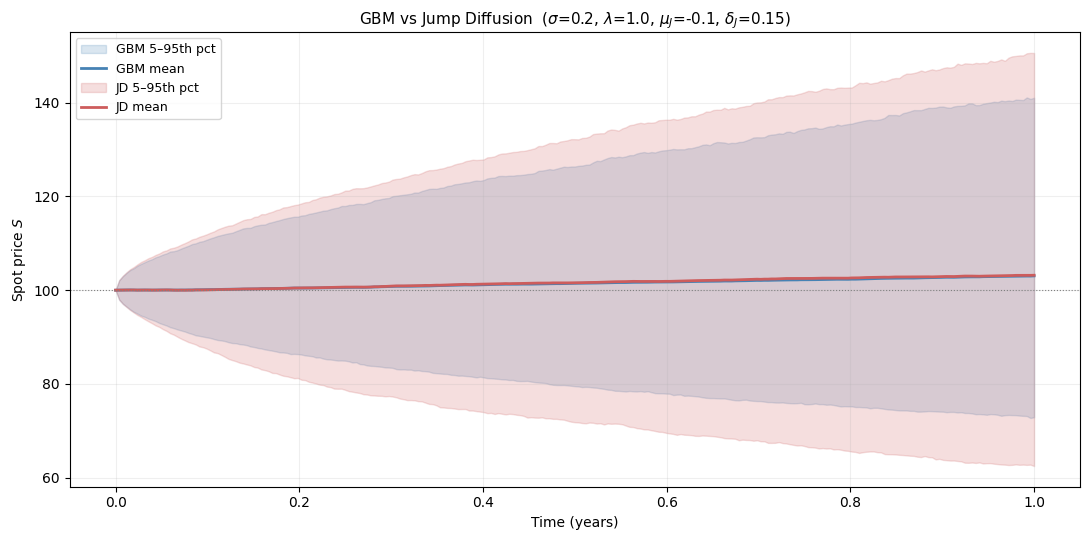


Terminal distribution (t = 1.0):
                       Mean       Std       5th      95th      Skew
  GBM                103.05     21.04     72.88    141.09    0.6576
  Jump Diffusion     103.19     26.89     62.44    150.64    0.5280


In [12]:
# ── GBM vs Jump Diffusion — percentile bands on the same plot ──────────
N_jd = 252
M_jd = 10_000  # many paths for smooth percentile envelopes
dt_jd = T / N_jd
rng_jd = np.random.default_rng(456)

# Shared diffusion draws — same Z for both GBM and JD so the
# only difference in paths comes from the jump component
Z_jd = rng_jd.standard_normal((N_jd, M_jd))

# --- GBM paths (same Z) ---
drift_gbm2 = (r - q - 0.5 * sigma**2) * dt_jd
log_inc_gbm2 = np.vstack(
    [np.zeros(M_jd), np.full((N_jd, M_jd), drift_gbm2) + sigma * np.sqrt(dt_jd) * Z_jd]
)
paths_gbm2 = S0 * np.exp(np.cumsum(log_inc_gbm2, axis=0))

# --- Jump diffusion paths (same Z + jumps) ---
# Step 1: sample N_Δ for every (time step, path) — Poisson(λ·Δt)
poi_counts = rng_jd.poisson(lambd * dt_jd, size=(N_jd, M_jd))
# Step 2: sample Z_J for every (time step, path) — N(0,1)
jump_normals = rng_jd.standard_normal((N_jd, M_jd))

drift_jd = (r - q - lambd * k_bar - 0.5 * sigma**2) * dt_jd
diffusion_jd = sigma * np.sqrt(dt_jd) * Z_jd

# Step 3: total jump magnitude = N_Δ·μ_J + √N_Δ·δ_J·Z_J
# The np.where guard is not strictly necessary (the formula gives 0
# when poi_counts=0), but makes the "no jump" case explicit
jump_mag = np.where(
    poi_counts > 0,
    poi_counts * mu_J + np.sqrt(poi_counts) * delta_J * jump_normals,
    0.0,
)
log_inc_jd = np.vstack([np.zeros(M_jd), np.full((N_jd, M_jd), drift_jd) + diffusion_jd + jump_mag])
paths_jd = S0 * np.exp(np.cumsum(log_inc_jd, axis=0))

t_axis_jd = np.linspace(0, T, N_jd + 1)

# Compute percentiles
pct_lo, pct_hi = 5, 95
gbm_mean = np.mean(paths_gbm2, axis=1)
gbm_lo = np.percentile(paths_gbm2, pct_lo, axis=1)
gbm_hi = np.percentile(paths_gbm2, pct_hi, axis=1)

jd_mean = np.mean(paths_jd, axis=1)
jd_lo = np.percentile(paths_jd, pct_lo, axis=1)
jd_hi = np.percentile(paths_jd, pct_hi, axis=1)

fig, ax = plt.subplots(figsize=(11, 5.5))

# GBM band
ax.fill_between(
    t_axis_jd, gbm_lo, gbm_hi, alpha=0.20, color="steelblue", label=f"GBM {pct_lo}–{pct_hi}th pct"
)
ax.plot(t_axis_jd, gbm_mean, lw=2, color="steelblue", label="GBM mean")

# JD band
ax.fill_between(
    t_axis_jd, jd_lo, jd_hi, alpha=0.20, color="indianred", label=f"JD {pct_lo}–{pct_hi}th pct"
)
ax.plot(t_axis_jd, jd_mean, lw=2, color="indianred", label="JD mean")

ax.axhline(S0, color="grey", ls=":", lw=0.8)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Spot price $S$")
ax.set_title(
    f"GBM vs Jump Diffusion  ($\\sigma$={sigma}, $\\lambda$={lambd}, "
    f"$\\mu_J$={mu_J}, $\\delta_J$={delta_J})",
    fontsize=11,
)
ax.legend(fontsize=9, loc="upper left")
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

print(f"\nTerminal distribution (t = {T}):")
print(f"  {'':15s}  {'Mean':>8s}  {'Std':>8s}  {'5th':>8s}  {'95th':>8s}  {'Skew':>8s}")
print(
    f"  {'GBM':15s}  {gbm_mean[-1]:8.2f}  {np.std(paths_gbm2[-1]):8.2f}"
    f"  {gbm_lo[-1]:8.2f}  {gbm_hi[-1]:8.2f}"
    f"  {float(np.mean(((paths_gbm2[-1] - gbm_mean[-1]) / np.std(paths_gbm2[-1])) ** 3)):8.4f}"
)
print(
    f"  {'Jump Diffusion':15s}  {jd_mean[-1]:8.2f}  {np.std(paths_jd[-1]):8.2f}"
    f"  {jd_lo[-1]:8.2f}  {jd_hi[-1]:8.2f}"
    f"  {float(np.mean(((paths_jd[-1] - jd_mean[-1]) / np.std(paths_jd[-1])) ** 3)):8.4f}"
)

In [13]:
# ── Price with the library's JDProcess engine ──────────────────────
num_paths_jd = 100_000
num_steps_jd = 100

sim_jd = SimulationConfig(
    paths=num_paths_jd,
    end_date=maturity,
    num_steps=num_steps_jd,
    antithetic=True,
    moment_matching=True,
)

jd_process = JDProcess(
    market_data=market_data,
    process_params=JDParams(
        initial_value=S0,
        volatility=sigma,
        lambd=lambd,
        mu=mu_J,
        delta=delta_J,
        dividend_curve=curve_q,
    ),
    sim=sim_jd,
)

ov_jd = OptionValuation(
    underlying=jd_process,
    spec=spec_call,
    pricing_method=PricingMethod.MONTE_CARLO,
    params=MonteCarloParams(random_seed=42),
)

jd_pv = ov_jd.present_value()

print(f"Jump diffusion MC (M={num_paths_jd:,}):       {jd_pv:.6f}")
print(f"BSM (no jumps):                      {bsm_pv:.6f}")
print(f"Difference:                          {jd_pv - bsm_pv:+.6f}")
print("\nWith negative mean jump (μ_J < 0), the left tail is fatter,")
print("which can increase ATM call prices vs BSM.")

Jump diffusion MC (M=100,000):       11.450802
BSM (no jumps):                      9.227006
Difference:                          +2.223796

With negative mean jump (μ_J < 0), the left tail is fatter,
which can increase ATM call prices vs BSM.


In [14]:
# Demonstrate JD process with λ=0 matches GBM (no jumps)
jd_process = JDProcess(
    market_data=market_data,
    process_params=JDParams(
        initial_value=S0,
        volatility=sigma,
        lambd=0,
        mu=mu_J,
        delta=delta_J,
        dividend_curve=curve_q,
    ),
    sim=sim_jd,
)

ov_jd = OptionValuation(
    underlying=jd_process,
    spec=spec_call,
    pricing_method=PricingMethod.MONTE_CARLO,
    params=MonteCarloParams(random_seed=42),
)

jd_pv = ov_jd.present_value()

print(f"JD process (λ=0) MC (M={num_paths_jd:,}): {jd_pv:.6f}")
print(f"BSM (no jumps):                  {bsm_pv:.6f}")
print(f"Difference:                      {jd_pv - bsm_pv:+.6f}")
print(f"Difference (%):                  {(jd_pv - bsm_pv) / bsm_pv * 100:+.2f}%")

JD process (λ=0) MC (M=100,000): 9.186077
BSM (no jumps):                  9.227006
Difference:                      -0.040928
Difference (%):                  -0.44%


## 9) American Options — Longstaff–Schwartz (2001)

Monte Carlo is inherently a **forward** simulation method, but American option pricing requires
**backward** induction (the holder decides at each point whether to exercise).  Longstaff and
Schwartz (2001) resolved this tension with a **least-squares** regression approach.

### Algorithm

1. **Simulate** $M$ paths of the underlying over $N$ time steps
2. At maturity ($t_N$): set the **cash flow** to the terminal intrinsic value
3. **Backward induction** — for $i = N{-}1, N{-}2, \ldots, 1$:
   - Identify **in-the-money** (ITM) paths at time $t_i$
   - For ITM paths, **regress** the discounted future cash flow on polynomial basis functions of the current spot: $\hat{C}(S_{t_i}) = \sum_{j=0}^{d} \beta_j S_{t_i}^j$
   - The regression output $\hat{C}(S_{t_i})$ is the **estimated continuation value**
   - **Exercise decision**: if intrinsic value $>$ estimated continuation value, exercise now
   - **Cash flow update**: for paths that exercise, the cash flow is set to the intrinsic value; for paths that don't exercise, the cash flow remains the **actual** (not estimated) discounted future cash flow
4. The option price is the average of the discounted optimal cash flows across all paths

### Key points

- Only **ITM** paths are used in the regression — this avoids trying to fit a polynomial where intrinsic value is zero (and the decision is trivially "don't exercise")
- The regression is used **only for the exercise decision**, not for the cash flow itself.  Once we decide to continue, the actual (simulated) future cash flow is carried backward — the regression estimate $\hat{C}$ is discarded
- The polynomial degree $d$ is typically 2–5 (controlled by `MonteCarloParams(deg=...)`)
- Unlike trees, LSM handles **high-dimensional** problems naturally (multiple underlyings, path-dependent features)

### Bias

In theory, LSM has a **downward bias**: noisy regression estimates cause some suboptimal
exercise decisions, which can only reduce the value relative to the true optimum.

In practice, however, the **MC standard error** (from sampling noise) often dominates. With
$M = 10{,}000$ paths and SE $\approx 0.08$, a positive deviation of $+0.06$ from the reference
is well within one standard error. As $M$ grows
the SE shrinks, and the downward bias (typically a few cents for vanilla puts) becomes visible.

Note also that the binomial reference is itself an **approximation** — with 2,000 steps it is
accurate to ~$0.01, so small discrepancies in either direction are expected.

> In `portfolio_analytics`, `_MCAmericanValuation` implements LSM using
> `numpy.polynomial.Polynomial.fit()` for the regression step.

In [22]:
# ── American put: LSM vs Binomial ─────────────────────────────────────
spec_am_put = OptionSpec(
    option_type=OptionType.PUT,
    exercise_type=ExerciseType.AMERICAN,
    strike=K,
    maturity=maturity,
    currency="USD",
)

spec_eur_put = OptionSpec(
    option_type=OptionType.PUT,
    exercise_type=ExerciseType.EUROPEAN,
    strike=K,
    maturity=maturity,
    currency="USD",
)

# Binomial reference (high accuracy)
ov_binom_am = OptionValuation(
    underlying=underlying,
    spec=spec_am_put,
    pricing_method=PricingMethod.BINOMIAL,
    params=BinomialParams(num_steps=2000),
)
pv_binom_am = ov_binom_am.present_value()

# BSM European put reference
ov_bsm_put = OptionValuation(
    underlying=underlying,
    spec=spec_eur_put,
    pricing_method=PricingMethod.BSM,
)
pv_bsm_put = ov_bsm_put.present_value()
# MC American put with varying path counts
print(f"{'M':>10s}  {'MC Am Put':>10s}  {'Std Error':>10s}  {'Binom Ref':>10s}  {'Error':>10s}")
print("-" * 60)

for n_mc in [10_000, 50_000, 100_000, 200_000]:
    gbm_am = make_gbm(n_mc, num_steps=100)
    ov_am = OptionValuation(
        underlying=gbm_am,
        spec=spec_am_put,
        pricing_method=PricingMethod.MONTE_CARLO,
        params=MonteCarloParams(random_seed=42, deg=3),
    )
    pv_pw = ov_am.present_value_pathwise()
    pv_am = float(np.mean(pv_pw))
    se_am = float(np.std(pv_pw, ddof=1) / np.sqrt(len(pv_pw)))
    print(
        f"{n_mc:10,d}  {pv_am:10.6f}  {se_am:10.6f}  {pv_binom_am:10.6f}  {pv_am - pv_binom_am:+10.6f}"
    )

print(f"\nBSM European Put:  {pv_bsm_put:.6f}")
print(f"Binomial Am Put:   {pv_binom_am:.6f}")
print(f"Early ex premium:  {pv_binom_am - pv_bsm_put:.6f}")
print("\nPositive errors at low M are sampling noise (SE ≈ 0.08 at M=10k).")
print("The theoretical downward bias is small and only emerges as M → ∞.")

         M   MC Am Put   Std Error   Binom Ref       Error
------------------------------------------------------------
    10,000    6.691193    0.077736    6.660226   +0.030967
    50,000    6.702981    0.034183    6.660226   +0.042755
   100,000    6.658119    0.024359    6.660226   -0.002107
   200,000    6.657781    0.017152    6.660226   -0.002444

BSM European Put:  6.330081
Binomial Am Put:   6.660226
Early ex premium:  0.330145

Positive errors at low M are sampling noise (SE ≈ 0.08 at M=10k).
The theoretical downward bias is small and only emerges as M → ∞.


In [17]:
# ── LSM polynomial degree sensitivity ─────────────────────────────────
gbm_deg = make_gbm(100_000, num_steps=100)

print(f"{'Degree':>8s}  {'MC Am Put':>10s}  {'Error vs Binom':>14s} {'Error vs Binom (%)':>14s}")
print("-" * 52)
for d in [1, 2, 3, 4, 5]:
    ov_d = OptionValuation(
        underlying=gbm_deg,
        spec=spec_am_put,
        pricing_method=PricingMethod.MONTE_CARLO,
        params=MonteCarloParams(random_seed=42, deg=d),
    )
    pv_d = ov_d.present_value()
    error_vs_binom = pv_d - pv_binom_am
    error_vs_binom_pct = (error_vs_binom / pv_binom_am) * 100
    print(f"{d:8d}  {pv_d:10.6f}  {error_vs_binom:+14.6f}  {error_vs_binom_pct:+14.2f}%")

  Degree   MC Am Put  Error vs Binom Error vs Binom (%)
----------------------------------------------------
       1    6.584370       -0.075856           -1.14%
       2    6.638144       -0.022081           -0.33%
       3    6.658119       -0.002107           -0.03%
       4    6.671826       +0.011601           +0.17%
       5    6.669434       +0.009209           +0.14%


## 10) Greeks via Monte Carlo

Monte Carlo Greeks are typically computed via **bump-and-revalue** (also called finite differences on the model):

$$\Delta \approx \frac{V(S_0 + h) - V(S_0 - h)}{2h}, \qquad \Gamma \approx \frac{V(S_0 + h) - 2V(S_0) + V(S_0 - h)}{h^2}.$$

Each bump creates a new `OptionValuation` instance via `underlying.replace(...)` — the original
object is never mutated.

More sophisticated methods (pathwise/likelihood ratio) exist but are not yet implemented
in the library.

> In `portfolio_analytics`, MC Greeks default to `GreekCalculationMethod.NUMERICAL`
> (bump-and-revalue).  The bump size is chosen automatically.

In [18]:
# ── MC Greeks vs BSM analytical ───────────────────────────────────────
gbm_greeks = make_gbm(100_000)

ov_mc_greeks = OptionValuation(
    underlying=gbm_greeks,
    spec=spec_call,
    pricing_method=PricingMethod.MONTE_CARLO,
    params=MonteCarloParams(random_seed=42),
)

print(f"{'Greek':>8s}  {'MC (bump)':>10s}  {'BSM':>10s}  {'Diff':>10s}")
print("-" * 45)
for greek_name in ["delta", "gamma", "vega", "theta", "rho"]:
    mc_val = getattr(ov_mc_greeks, greek_name)()
    bsm_val = getattr(bsm_ov, greek_name)()
    print(f"{greek_name:>8s}  {mc_val:10.6f}  {bsm_val:10.6f}  {mc_val - bsm_val:+10.6f}")

   Greek   MC (bump)         BSM        Diff
---------------------------------------------
   delta    0.587427    0.586851   +0.000576
   gamma    0.019669    0.018951   +0.000718
    vega    0.378237    0.379012   -0.000775
   theta    0.004389   -0.013943   +0.018332
     rho    0.495427    0.494581   +0.000846


/workspaces/portfolio_analytics/src/portfolio_analytics/rates.py:143: UserWarning: Extrapolating discount curve outside [0.0000, 1.0000] — flat log-DF assumed
  df0 = float(self.df(t0))


## 11) Convergence and Diagnostics

The MC price converges to the true price at rate $\mathcal{O}(1/\sqrt{M})$.  The plot below
shows how the estimate stabilises as we increase the number of paths, with 95% confidence
interval bands shown.

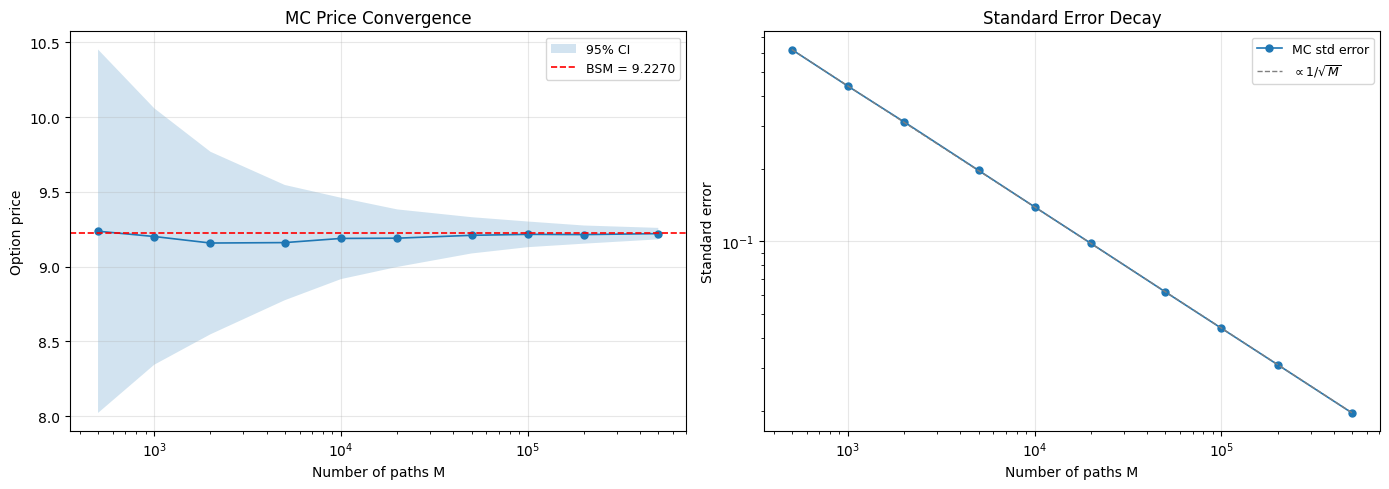

In [19]:
# ── Convergence: price vs number of paths ──────────────────────────────
path_counts = [500, 1000, 2000, 5000, 10_000, 20_000, 50_000, 100_000, 200_000, 500_000]
mc_prices = []
mc_ses = []

for n in path_counts:
    gbm_conv = make_gbm(n)
    ov_conv = OptionValuation(
        underlying=gbm_conv,
        spec=spec_call,
        pricing_method=PricingMethod.MONTE_CARLO,
        params=MonteCarloParams(random_seed=42),
    )
    pv_pw = ov_conv.present_value_pathwise()
    mc_prices.append(float(np.mean(pv_pw)))
    mc_ses.append(float(np.std(pv_pw, ddof=1) / np.sqrt(len(pv_pw))))

mc_prices = np.array(mc_prices)
mc_ses = np.array(mc_ses)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price convergence
ax = axes[0]
ax.semilogx(path_counts, mc_prices, "o-", markersize=5, lw=1.2)
ax.fill_between(
    path_counts, mc_prices - 1.96 * mc_ses, mc_prices + 1.96 * mc_ses, alpha=0.2, label="95% CI"
)
ax.axhline(bsm_pv, color="red", ls="--", lw=1.2, label=f"BSM = {bsm_pv:.4f}")
ax.set_xlabel("Number of paths M")
ax.set_ylabel("Option price")
ax.set_title("MC Price Convergence")
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Standard error decay
ax2 = axes[1]
ax2.loglog(path_counts, mc_ses, "o-", markersize=5, lw=1.2, label="MC std error")
# Theoretical 1/sqrt(M) reference line
ref_se = mc_ses[0] * np.sqrt(path_counts[0]) / np.sqrt(path_counts)
ax2.loglog(path_counts, ref_se, "--", color="grey", lw=1, label=r"$\propto 1/\sqrt{M}$")
ax2.set_xlabel("Number of paths M")
ax2.set_ylabel("Standard error")
ax2.set_title("Standard Error Decay")
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# ── Seed sensitivity ──────────────────────────────────────────────────
gbm_seed = make_gbm(100_000)

seeds = range(1, 21)
seed_prices = []
for s in seeds:
    ov_s = OptionValuation(
        underlying=gbm_seed,
        spec=spec_call,
        pricing_method=PricingMethod.MONTE_CARLO,
        params=MonteCarloParams(random_seed=s),
    )
    seed_prices.append(ov_s.present_value())

seed_prices = np.array(seed_prices)
print("Price across 20 seeds (M=100,000):")
print(f"  Mean:   {np.mean(seed_prices):.6f}")
print(f"  Std:    {np.std(seed_prices, ddof=1):.6f}")
print(f"  Min:    {np.min(seed_prices):.6f}")
print(f"  Max:    {np.max(seed_prices):.6f}")
print(f"  Range:  {np.max(seed_prices) - np.min(seed_prices):.6f}")
print(f"  BSM:    {bsm_pv:.6f}")

Price across 20 seeds (M=100,000):
  Mean:   9.226808
  Std:    0.009830
  Min:    9.212514
  Max:    9.247111
  Range:  0.034597
  BSM:    9.227006


## 12) Discrete Dividends in Monte Carlo

So far we have modelled dividends as a **continuous yield** $q$, baked into the drift:

$$dS = (r - q)\,S\,dt + \sigma\,S\,dW.$$

This is convenient — the yield enters the drift once and needs no special handling during the
simulation.  But stocks pay **discrete** cash dividends on known ex-dates, and for
short-dated options or options near an ex-date, the continuous approximation can introduce
meaningful pricing error.

### The idea

With Monte Carlo, discrete dividends are straightforward: **simulate the stochastic process as
usual, and at each ex-date subtract the dividend amount from the stock price**.

At each time step $t$:

1. Evolve the stock price via the usual GBM (or jump-diffusion) log-increment:
$$S_{t+\Delta t}^{-} = S_t \exp\!\bigl[(r - \tfrac{1}{2}\sigma^2)\Delta t + \sigma\sqrt{\Delta t}\,Z\bigr]$$

2. Check if time $t + \Delta t$ coincides with an ex-dividend date.  If so, subtract the
   dividend $D$ and **floor at zero**:
$$S_{t+\Delta t} = \max\!\bigl(S_{t+\Delta t}^{-} - D,\; 0\bigr).$$

3. Continue the simulation from the adjusted price $S_{t+\Delta t}$.

The zero floor ensures the stock price never goes negative — for reasonable parameterisations
this truncation is never triggered, but it is a safety net.

> **Note:** the above formula omits q in the drift, assuming if discrete dividends are modeled, the continuous
dividend yield is set to 0. This is standard practice - either price the option assuming discrete 
dividends **or** continuous yields. That bei said, the library does let you model both at once; 
such a scenario might involve modeling near-term dividends as discrete and specifying continuous 
yields further out.

### Why the time grid matters

For the subtraction to happen at the right moment, the ex-dividend dates must fall **exactly**
on a time-grid point.  If they don't, the dividend is missed.  The library handles
this: when `discrete_dividends` are specified, `GBMProcess` (and `JDProcess`)
it inserts the ex-dates into the simulation time grid as **observation dates**, guaranteeing they
appear as grid points regardless of the `num_steps` setting.

### Implementation note

In the no-dividend (or continuous-yield) case, `GBMProcess.generate_paths()` computes all
log-increments as a matrix and uses `cumsum` + `exp` — fully vectorised, no Python loop.
When discrete dividends are present, this trick breaks down: the subtraction at each ex-date
is an **additive** operation in price-space that interrupts the multiplicative (log-space)
accumulation.  So the library falls back to a **step-by-step loop**: at each time step it
computes the log-increment, exponentiates, subtracts any dividend, and continues.  This is
slower but unavoidable — the subtractive dividend turns the simulation into a path-dependent,
non-multiplicative process.

### Pricing-date dividends ($t = 0$)

If an ex-date falls on the **pricing date** itself, the input spot price $S_0$ is assumed to be
**cum-dividend** (i.e. the market-observed price before the stock goes ex).  The library
immediately subtracts the dividend at $t = 0$, so the simulation starts from the ex-dividend
price:

$$S_0^{\text{ex}} = \max(S_0 - D_0,\; 0).$$

In [21]:
# ── Discrete dividends: MC example ──────────
# Two $2 dividends at 3 and 9 months. Dividends reduce stock price
# For a call option, dividends will reduce the option value
ex_dates = [
    (dt.datetime(2025, 4, 1), 2.0),
    (dt.datetime(2025, 10, 1), 2.0),
]

# 1) MC with discrete dividends
sim_div = SimulationConfig(
    paths=100_000,
    end_date=maturity,
    num_steps=100,
    antithetic=True,
    moment_matching=True,
)
gbm_disc = GBMProcess(
    market_data=market_data,
    process_params=GBMParams(
        initial_value=S0,
        volatility=sigma,
        discrete_dividends=ex_dates,
    ),
    sim=sim_div,
)
ov_disc = OptionValuation(
    underlying=gbm_disc,
    spec=spec_call,
    pricing_method=PricingMethod.MONTE_CARLO,
    params=MonteCarloParams(random_seed=42),
)
pv_disc = ov_disc.present_value()

gbm_no_divs = GBMProcess(
    market_data=market_data,
    process_params=GBMParams(
        initial_value=S0,
        volatility=sigma,
    ),
    sim=sim_div,
)

ov_no_divs = OptionValuation(
    underlying=gbm_no_divs,
    spec=spec_call,
    pricing_method=PricingMethod.MONTE_CARLO,
    params=MonteCarloParams(random_seed=42),
)
pv_no_divs = ov_no_divs.present_value()

print("European call with $2 dividends at 3-month and 9-month marks")
print(f"  Discrete div (MC):        {pv_disc:.4f}")
print(f"  No divs (MC):             {pv_no_divs:.4f}")
print(f"Dividend impact on option price:   {pv_disc - pv_no_divs:+.4f}")

European call with $2 dividends at 3-month and 9-month marks
  Discrete div (MC):        8.3364
  No divs (MC):             10.5185
Dividend impact on option price:   -2.1820


---

## 13) Summary

| Topic | Key takeaway |
|---|---|
| **GBM SDE** | $dS = (r-q)S\,dt + \sigma S\,dW$; exact solution via $\exp(\cdot)$ |
| **Log-space Euler** | $X_{t+\Delta t} = X_t + (r-q-\frac{1}{2}\sigma^2)\Delta t + \sigma\sqrt{\Delta t}\,Z$; exact for GBM |
| **European pricing** | Single-step simulation, average payoff, discount; SE $\propto 1/\sqrt{M}$ |
| **Variance reduction** | Antithetic variates ($Z, -Z$), moment matching, control variates |
| **Jump diffusion** | Merton (1976): add Poisson jumps to GBM; requires time stepping |
| **American (LSM)** | Regress discounted CV on basis functions of $S$; inherently downward biased |
| **Greeks** | Bump-and-revalue via `underlying.replace(...)`; no mutation |
| **Convergence** | $\mathcal{O}(1/\sqrt{M})$; use 95% CI for error assessment |
| **Discrete dividends** | Subtract $D$ at each ex-date, floor at zero; breaks vectorised log-space trick |

### What's not covered here

- **Asian options** — covered in a dedicated notebook (path-dependent averaging mechanics)
- **Stochastic volatility / stochastic rates** — not (yet) implemented in the library
- **Pathwise / likelihood ratio Greeks**

**References:**
- Glasserman, *Monte Carlo Methods in Financial Engineering* (2003)
- Longstaff & Schwartz, *Valuing American Options by Simulation* (2001)
- Merton, *Option Pricing When Underlying Stock Returns Are Discontinuous* (1976)

---

## Appendix: Deriving the Exact Solution of the GBM SDE

### A.1 — Itô processes and Itô's lemma

A general **Itô process** for a variable $S$ has the form

$$dS = a(S, t)\,dt + b(S, t)\,dW,$$

where $a(S,t)$ is the **drift** and $b(S,t)$ is the **diffusion coefficient**, both of which may depend on the current value $S$ and time $t$, and $W$ is a standard Brownian motion.

Let $G(S, t)$ be a twice-differentiable function of $S$ and $t$.  **Itô's lemma** states that

$$dG = \left(\frac{\partial G}{\partial S}\,a + \frac{\partial G}{\partial t} + \frac{1}{2}\,\frac{\partial^2 G}{\partial S^2}\,b^2\right)dt + \frac{\partial G}{\partial S}\,b\,dW.$$

The extra second-order term $\frac{1}{2}\,\frac{\partial^2 G}{\partial S^2}\,b^2$ is the key difference from ordinary calculus — it arises because $(dW)^2 = dt$ in the Itô framework.

### A.2 — Applying Itô's lemma to $G = \ln S$

For **Geometric Brownian Motion** the SDE is

$$dS = \mu\,S\,dt + \sigma\,S\,dW,$$

so $a(S,t) = \mu S$ and $b(S,t) = \sigma S$.  (In the risk-neutral measure, $\mu = r - q$.)

Choose $G = \ln S$.  The required partial derivatives are:

$$\frac{\partial G}{\partial S} = \frac{1}{S}, \qquad \frac{\partial^2 G}{\partial S^2} = -\frac{1}{S^2}, \qquad \frac{\partial G}{\partial t} = 0.$$

Substituting into Itô's lemma:

$$d(\ln S) = \left(\frac{1}{S}\cdot\mu S + 0 + \frac{1}{2}\left(-\frac{1}{S^2}\right)(\sigma S)^2\right)dt + \frac{1}{S}\cdot\sigma S\,dW$$

$$\boxed{d(\ln S) = \left(\mu - \tfrac{1}{2}\sigma^2\right)dt + \sigma\,dW.}$$

This is the central result: the log-price follows an **arithmetic Brownian motion** with constant drift $\mu - \frac{1}{2}\sigma^2$ and constant diffusion $\sigma$.

### A.3 — Distribution of $\ln S_T$

Since $d(\ln S)$ has **constant coefficients** — the drift and diffusion do not depend on $S$ or $t$ — we can integrate directly from $0$ to $T$:

$$\ln S_T - \ln S_0 = \left(\mu - \tfrac{1}{2}\sigma^2\right)T + \sigma\,W_T.$$

Because $W_T \sim \mathcal{N}(0, T)$, the log-price at maturity is normally distributed:

$$\boxed{\ln S_T \sim \mathcal{N}\!\left(\ln S_0 + \left(\mu - \tfrac{1}{2}\sigma^2\right)T,\;\sigma^2 T\right).}$$

Equivalently, $S_T$ is **lognormally distributed** — this is the foundation of the Black–Scholes–Merton formula.

### A.4 — The exact solution and why Euler discretisation is exact for GBM

Exponentiating the integrated log-price gives the **exact solution**:

$$\boxed{S_T = S_0 \exp\!\left[\left(\mu - \tfrac{1}{2}\sigma^2\right)T + \sigma\,W_T\right].}$$

For simulation, we discretise over a time step $\Delta t$.  The Euler–Maruyama scheme applied to the log-price SDE gives:

$$\ln S_{t+\Delta t} = \ln S_t + \left(\mu - \tfrac{1}{2}\sigma^2\right)\Delta t + \sigma\sqrt{\Delta t}\;Z, \qquad Z \sim \mathcal{N}(0,1).$$

**This Euler step is exact** — there is no discretisation error.  The reason is that the log-price SDE

$$d(\ln S) = \left(\mu - \tfrac{1}{2}\sigma^2\right)dt + \sigma\,dW$$

is a **linear SDE with constant coefficients**: the drift and diffusion are both constant (they do not depend on $\ln S$ or $t$).  Because the SDE is *affine* in the Brownian motion, the finite-difference approximation

$$\Delta(\ln S) = \left(\mu - \tfrac{1}{2}\sigma^2\right)\Delta t + \sigma\,\Delta W$$

captures the transition distribution *exactly* for any step size $\Delta t$.

This is why, for European options under GBM, a **single-step** simulation ($N=1$) from $t=0$ to $T$ is sufficient — there is no need to time-step through intermediate dates.  Path-dependent payoffs (Asian, barrier) and SDEs with state-dependent coefficients (stochastic volatility, mean-reverting processes) do require fine time-stepping because their Euler schemes are no longer exact.

**Reference:** Hull, *Options, Futures, and Other Derivatives*, Chapter 14 (Wiener processes and Itô's lemma).